In [1]:
import altair as alt
import pandas as pd 
import numpy as np

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Proof of concept viz

## Data processing for example 1

In [2]:
example1 = pd.read_csv('../server/example1/examplematch1.robotdata.csv')

In [11]:
example1.shape, example1.columns

((148, 114),
 Index(['id', 'name', 'expires', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6',
        't_7',
        ...
        'Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity'],
       dtype='object', length=114))

In [12]:
example1_robots = example1[['id','name','expires', 'Repulsorlift Motor HP','Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity']]

In [13]:
example1_robots.sample()

id                  name  expires  Repulsorlift Motor HP  \
72  72  Pushminer Botberg II     56.0             -81.784504   

    Astrogation Buffer Length  Polarity Sinks Arakyd Vocabulator Model  \
72                  -0.211206        0.492593                  model D   

   Axial Piston Model Nanochip Model  AutoTerrain Tread Count  InfoCore Size  \
72              gamma           v2.0                 1.254415       1.250756   

    Sonoreceptors  Cranial Uplink Bandwidth  Productivity  
72           23.0                      64.0     97.682974

In [44]:
example1_timeseries = example1.drop(['expires','Repulsorlift Motor HP' ,'Astrogation Buffer Length', 'Polarity Sinks',
        'Arakyd Vocabulator Model', 'Axial Piston Model', 'Nanochip Model',
        'AutoTerrain Tread Count', 'InfoCore Size', 'Sonoreceptors',
        'Cranial Uplink Bandwidth', 'Productivity'], axis = 1)

In [45]:
example1_timeseries.sample()

id                 name  t_1        t_2       t_3        t_4        t_5  \
66  66  Stonewalker Botchik  0.0  10.016594  19.37179  28.088106  36.187728   

          t_6        t_7        t_8  ...       t_91       t_92       t_93  \
66  43.692513  50.623985  57.003341  ...  53.658981  55.515021  57.412944   

        t_94      t_95       t_96       t_97       t_98      t_99      t_100  
66  59.34553  61.30523  63.284164  65.274123  67.266565  69.25262  71.223086  

[1 rows x 102 columns]

In [46]:
example1_timeseries_melted = example1_timeseries.melt(id_vars = ['id','name'], var_name = 'time', value_name = 'number')

In [47]:
example1_timeseries_melted['timestamp'] = example1_timeseries_melted['time']
example1_timeseries_melted['time'] = example1_timeseries_melted['timestamp'].str.split('_',expand = True)[1].astype(int)

In [50]:
example1_timeseries_melted.sort_values(by = ['id','time'], ascending = True, inplace = True)
example1_timeseries_melted.sample(5)

id                   name  time     number timestamp
1309   125     Waterhauler Botski     9  55.156321       t_9
12379   95      Waterborer Botski    84   3.778412      t_84
11892   52      Wallhauler Botski    81  34.415927      t_81
13329    9   Wallvator Boterson I    91  46.605340      t_91
1415    83  Pulldigger Botberg II    10  36.427667      t_10

## Timeseries viz for example 1

In [52]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [283]:
timeseries_base_dot = alt.Chart(example1_timeseries_melted).mark_point(
    filled = True, 
    size = 1, 
    opacity = 0.5
).encode(
    x = alt.X('time:Q'),
    y = alt.Y('number:Q')
)

timeseries_base_regression = timeseries_base_dot.transform_regression(
    'time', 'number', method = 'poly', order = 4
).mark_line(opacity = 0.5)

# timeseries_base_r2 = timeseries_base_dot.transform_regression(
#     'time', 'number', method = 'poly', params=True, order = 5
# ).mark_text(align='left').encode(
#     x=alt.value(70),  
#     y=alt.value(20), 
#     text=alt.Text('rSquared:N', format = '.2f', title = 'r2')
# ) 

# timeseries_base_r2label = timeseries_base_r2.encode(
#     x=alt.value(10),  
#     y=alt.value(20), 
#     text=alt.value('R-squared: ')
# )

timeseries_base = alt.layer( timeseries_base_dot + timeseries_base_regression)
timeseries_base

alt.LayerChart(...)

In [285]:
robot_dropdown = alt.binding_select(options=list(example1.id.unique()))
robot_select = alt.selection_single(fields=['id'], bind=robot_dropdown, name="Robot", empty = 'none', init = {'id':0})

timeseries_robot_dot = timeseries_base_dot.mark_point(
    size = 3, 
    opacity = 1
)

timeseries_robot_regression = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', order = 4
).mark_line()

timeseries_robot_r2 = timeseries_robot_dot.transform_regression(
    'time', 'number', method = 'poly', params=True, order = 4
).mark_text(align='left').encode(
    x=alt.value(160),  
    y=alt.value(20), 
    text=alt.Text('rSquared:N', format = '.2f', title = 'r2')
) 

timeseries_robot_r2label = timeseries_robot_r2.encode(
    x=alt.value(10),  
    y=alt.value(20), 
    text=alt.value('R-squared for selected robot: ')
)


timeseries_robot = alt.layer( timeseries_robot_dot + timeseries_robot_regression + timeseries_robot_r2 + timeseries_robot_r2label).add_selection(
    robot_select
).transform_filter(
    robot_select
)
timeseries_base + timeseries_robot

alt.LayerChart(...)

In [247]:
example1_timeseries_melted[['id','number']].groupby(by = 'id').count().sort_values(by = 'number', ascending = False).head(10)



number
id         
0       100
1       100
2       100
3       100
4       100
..      ...
143     100
144     100
145     100
146     100
147     100

[148 rows x 1 columns]

## Adding on the tree viz

In [67]:
import networkx as nx

In [70]:
import json
with open('../server/example1/examplematch1.tree.json') as f:
  example1_tree_json = json.load(f)
example1_tree = nx.tree_graph(example1_tree_json)

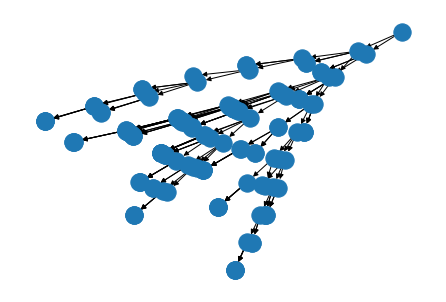

In [83]:
nx.draw_kamada_kawai(example1_tree)

In [259]:
def find_family(depth, node, graph):
    print (node)
    # find all predecessors and successors, up and down given depth    
    pred = []
    succ = []
    cur_level = [node]
    for _ in range(depth):
        next_level = list()
        for cur in cur_level:
            next_level += list(graph.predecessors(cur))
        cur_level = next_level
        pred += cur_level 
    cur_level = [node]
    for _ in range(depth):
        next_level = list()
        for cur in cur_level:
            next_level += list(graph.successors(cur))
        cur_level = next_level
        succ += cur_level 
    return pred+succ
# find_family(1,123,example1_tree)

In [267]:
robot_dropdown = alt.binding_select(options=list(example1.id.unique()))
robot_select = alt.selection_single(fields=['id'], bind=robot_dropdown, name="Robot", empty = 'none', init = {'id':0})

timeseries_robot = alt.Chart(example1_timeseries_melted).mark_point(
    filled = True, 
    size = 10, 
    opacity = 1
).encode(
    x = alt.X('time:Q'),
    y = alt.Y('number:Q')
).add_selection(
    robot_select
).transform_filter(
    robot_select
)

timeseries_robot

alt.Chart(...)

In [137]:
# example1_timeseries_melted

id                 name  time     number timestamp
0        0  Extraminer Boterson     1   0.000000       t_1
148      0  Extraminer Boterson     2  10.188414       t_2
296      0  Extraminer Boterson     3  19.509512       t_3
444      0  Extraminer Boterson     4  28.001504       t_4
592      0  Extraminer Boterson     5  35.701884       t_5
...    ...                  ...   ...        ...       ...
14207  147  Stoneminer Boterson    96  67.709511      t_96
14355  147  Stoneminer Boterson    97  67.102555      t_97
14503  147  Stoneminer Boterson    98  66.348602      t_98
14651  147  Stoneminer Boterson    99  65.435123      t_99
14799  147  Stoneminer Boterson   100  64.349223     t_100

[14800 rows x 5 columns]

KeyError: 0